# Preparing Data 4 the AE

### Import and function definition

In [1]:
import pandas as pd
import numpy as np
import timeit, math, os, copy, yaml, ast
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
#%load_ext memory_profiler

In [2]:
def Make_img(histo, Xbins, Xmin, Xmax, Ybins, Ymin, Ymax):
    img = np.zeros((100, 100), dtype=np.float32)
    
    for i in range(int(Ybins)):
        for j in range(int(Xbins)):
            img[i, j] = histo[i][j]#histo[i*(int(Xbins)+2)+j]
    #img = img[1:-1, 1:-1]
    return img
    
def Show2Dimg(img, title='CSC occupancy'):
    img_temp = copy.deepcopy(img)
    cmap = plt.cm.jet
    cmap.set_under(color='white')
    max_=np.max(img_temp)
    img_temp[img_temp==0] = np.nan
    plt.imshow(img_temp, cmap=cmap, vmin=0.0000000001, vmax=max_)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    del img_temp
    #plt.savefig('CSC_occupancy.png')

In [3]:
def Show1Dimg(vx, vy, xfit=None, yfit=None, x=r"Lumi [10$^{33}$ cm$^{-2}$ s$^{-1}$]", y="Occupancy (Hits/LS)", eymin=4, eymax=4, marker='.', line=False):
    plt.figure(figsize=(7, 4))
    if line==True:
        plt.axvline(x=9, color='red', linestyle='--')
    plt.plot(vx, vy, marker=marker, linestyle='', markersize=5, label='Data')
    if yfit is not None:
        plt.plot(xfit, yfit, color='red', label='Fit')
        plt.legend()
    plt.xlabel(x, size='14')
    plt.ylabel(y, size='14')
    #plt.ylim(0, 2000000)
    plt.grid(True)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(eymin,eymax))
    plt.rc('xtick', labelsize='12')
    plt.rc('ytick', labelsize='12')
    plt.title(r'$\mathbf{CMS}\ \mathit{Private\ work}$', x=0.24, y=1.0, size=14)
    #plt.title('CMS', fontweight='bold',x=0.12, y=1.0, size=14)
    plt.title('2023 (13.6 TeV)',loc='right', size=14)
    plt.legend()
    plt.show()

In [10]:
me = "hRHGlobalm3"
monitoring_elements = pd.read_parquet(me+'_files_p1.parquet')

In [11]:
#removing from dataset instances corresponding to zero inst luminosity
monitoring_elements = monitoring_elements[monitoring_elements["mean_lumi"] > 2]

In [12]:
#normalising to lumi/1000 to get entries * pb-1s-1 as unit
monitoring_elements["data_norm"] = monitoring_elements["data"]/(0.001*monitoring_elements["mean_lumi"])
monitoring_elements["entries_norm"] = monitoring_elements["entries"]/(0.001*monitoring_elements["mean_lumi"])

### Occupancy Plots

#### Occupancy vs Lumi

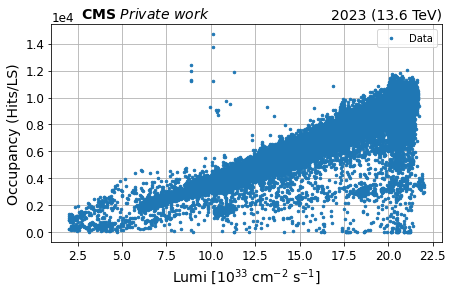

In [14]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries'])

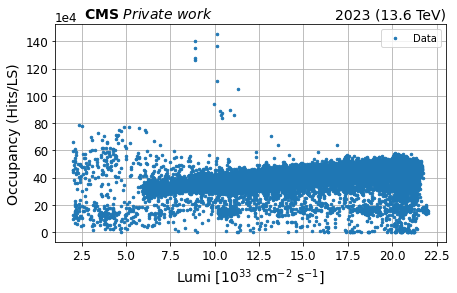

In [15]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries_norm'])

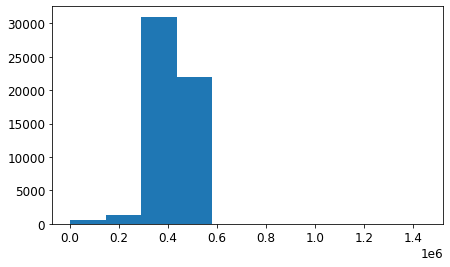

In [16]:
plt.figure(figsize=(7, 4))
plt.hist(monitoring_elements['entries_norm'] )
plt.show()

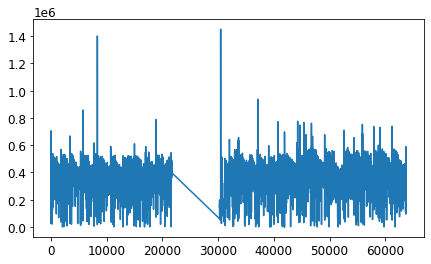

In [17]:
plt.figure(figsize=(7, 4))
plt.plot(monitoring_elements['entries_norm'])
plt.show()

In [18]:
mean_entries_norm = np.mean(monitoring_elements['entries_norm'])
std_entries_norm = np.std(monitoring_elements['entries_norm'])
up = mean_entries_norm+1*std_entries_norm
down = mean_entries_norm-1*std_entries_norm

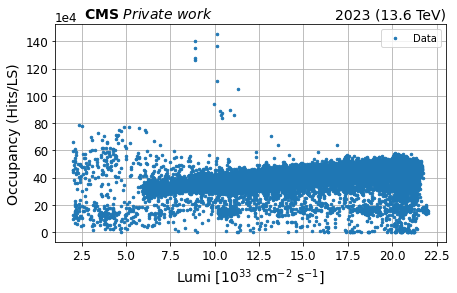

In [19]:
#remove outliers
monitoring_elements = monitoring_elements[((monitoring_elements["entries_norm"] > down) | (monitoring_elements["entries_norm"] < up) )]
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries_norm'])

In [28]:
monitoring_elements = monitoring_elements.reset_index()

### Sum over LS

Mean lumi: 2.181817071533


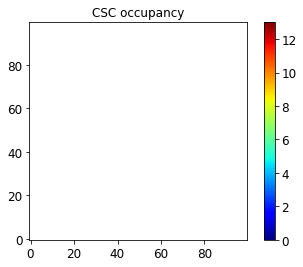

Mean lumi: 20.068316992187498


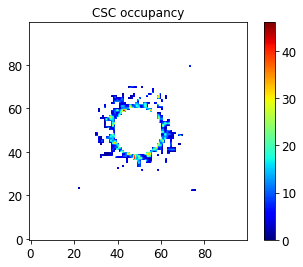

In [29]:
print("Mean lumi:", monitoring_elements["mean_lumi"][0])
img = Make_img(monitoring_elements['data'][0], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)
print("Mean lumi:", monitoring_elements["mean_lumi"][2000])
img = Make_img(monitoring_elements['data'][2000], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)

In [52]:
def hadd_img(df, lumi_threshold):
    count = 0
    summed_img = []
    summed_lumi = []
    summed_entries = []
    summed_number = []
    dfs = []
    count = 0
    for it in range(len(df)):
        new_row = {'data_norm': df['data_norm'][it], 'lumi': df['mean_lumi'][it], 'entries_norm': df['entries_norm'][it]}
        dfs.append(new_row)
        count +=1
        df_temp = pd.DataFrame(dfs)
        sumlumi = sum(df_temp['lumi'])
        if sumlumi >lumi_threshold: #to be divided by 1000 to get pb-1/s
            sumdata = sum(df_temp['data_norm'])
            summed_img.append(Make_img(sumdata, df['x_bin'][0], df['x_min'][0], df['x_max'][0], df['y_bin'][0], df['y_min'][0], df['y_max'][0]))
            summed_lumi.append(sumlumi)
            summed_entries.append(sum(df_temp['entries_norm']))
            summed_number.append(count)
            count = 0
            dfs = []
            del sumdata
        del df_temp
        del sumlumi
        del new_row
    print("Total imgs: ",len(summed_img))
    return summed_img, summed_lumi, summed_entries, summed_number


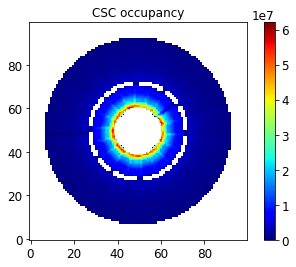

In [53]:
#have a look to the total (summed) distribution
sum_img = Make_img(sum(monitoring_elements['data_norm']), monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(sum_img)

In [54]:
#hadding consecutive ls to get a given total lumi
imgs, lumis, entry, num = hadd_img(monitoring_elements, 300) #corresponds to 0.3 pb-1/s

Total imgs:  2953


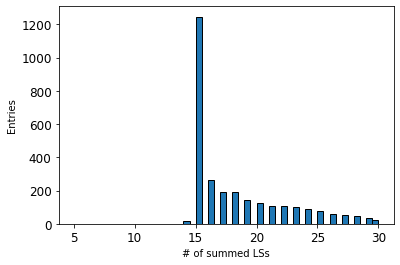

In [55]:
#this plot tells you how many consequent ls were summed up
plt.hist(num, bins=50, range=(5, 30), edgecolor='black')
plt.xlabel('# of summed LSs')
plt.ylabel('Entries')
plt.show()

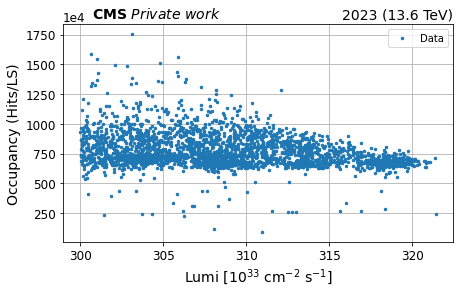

In [56]:
Show1Dimg(lumis, entry)

In [57]:
np.savez(me+'_files.npz', imgs=imgs, lumis=lumis, entry=entry, num=num)